In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42   # embed TrueType (selectable/copyable)
mpl.rcParams['ps.fonttype']  = 42   # same for .ps if you ever use it
mpl.rcParams['text.usetex']  = False  # unless you’re using the PGF route below
# optional: pick a common TTF so it embeds cleanly
mpl.rcParams['font.family'] = 'DejaVu Sans'

import matplotlib.pyplot as plt

import numpy as np
from numpy import random
import os
from ctd.comparison.analysis.tt.tt import Analysis_TT 
from ctd.comparison.analysis.dd.dd import Analysis_DD
# Import pca
import dotenv
from ctd.comparison.comparison import Comparison
import torch
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import math
import torch.nn.functional as F
dotenv.load_dotenv(dotenv.find_dotenv())
torch.manual_seed(42)
np.random.seed(42)


In [2]:
HOME_DIR = os.environ['HOME_DIR']
print(HOME_DIR)

pathTT = HOME_DIR + 'content/trained_models/task-trained/tt_RandomTarget/'
an_TT = Analysis_TT(run_name = "TT", filepath = pathTT)


path_NODE_Sweep = pathTT + "20250821_RandomTarget_LatentSweep_Smaller/"
subfolders_NODE = [f.path for f in os.scandir(path_NODE_Sweep) if f.is_dir()]


/home/csverst/Github/CtDBenchmark/


In [3]:
lex_TT_mean, lex_TT_std = an_TT.compute_lyapunov_exp(phase= "val")
print(f" Lyapunov exponent mean: {lex_TT_mean}, std: {lex_TT_std}")

 Lyapunov exponent mean: tensor([-0.0533, -0.0813, -0.1170, -0.1461, -0.1689, -0.2056, -0.2358, -0.2671,
        -0.2841, -0.3089, -0.3320, -0.3510, -0.4025, -0.4376, -0.4619, -0.5105,
        -0.5692, -0.5881, -0.6482, -0.6821, -0.7093, -0.7488, -0.7728, -0.7902,
        -0.8192, -0.8444, -0.8620, -0.8871, -0.9037, -0.9267, -0.9411, -0.9526,
        -0.9799, -0.9941, -1.0149, -1.0358, -1.0518, -1.0690, -1.0883, -1.1041,
        -1.1228, -1.1396, -1.1581, -1.1739, -1.1901, -1.2124, -1.2310, -1.2475,
        -1.2614, -1.2826, -1.3016, -1.3155, -1.3358, -1.3516, -1.3640, -1.3738,
        -1.3941, -1.4071, -1.4178, -1.4263, -1.4351, -1.4637, -1.4803, -1.4979,
        -1.5121, -1.5271, -1.5413, -1.5519, -1.5616, -1.5796, -1.5976, -1.6124,
        -1.6277, -1.6406, -1.6517, -1.6609, -1.6822, -1.6932, -1.7157, -1.7274,
        -1.7418, -1.7531, -1.7683, -1.7794, -1.7946, -1.8102, -1.8207, -1.8337,
        -1.8431, -1.8613, -1.8736, -1.8850, -1.9057, -1.9184, -1.9291, -1.9547,
        -1.9773

In [4]:
comparison = Comparison(comparison_tag="Figure1RandomTarget_TTGRU_Sweep")
comparison.load_analysis(an_TT, reference_analysis=True, group = "TT")

for subfolder in subfolders_NODE:
    subfolder = subfolder + "/"
    # Find int eh subfolder where latent_size is, and get the value after the = sign
    # split the subfolder name
    latent_size = subfolder.split("latent_size=")[1].split("_")[0]
    # Make string with no decimals
    
    analysis_NODE = Analysis_DD.create(run_name = f"NODE{latent_size}", filepath = subfolder, model_type = "SAE")
    comparison.load_analysis(analysis_NODE, group = f"NODE{latent_size}")

comparison.regroup()

In [5]:
# lex_mean_DD, lex_std_DD = analysis_NODE.compute_lyapunov_exp(phase= "val")
# print(f" Lyapunov exponent mean NODE: {lex_mean_DD}, std: {lex_std_DD}")

In [6]:
metric_dict_list = {
    'state_r2': {},
    'rate_r2': {},
    'cycle_con': {'variance_threshold': 0.01},
    'co-bps': {},
    'mmd': {'feature_types': ['pairwise', 'distances'],
            "max_pairwise_samples": 10000},
    'lyapunov': {},
    'nl_cycle_con': {'max_epochs': 1000, 'noise_stds': [0, 0.01, 0.05, 0.1, 0.25, 0.5]},
}
metrics = comparison.compute_metrics(metric_dict_list=metric_dict_list)



Working on 1 of 41: NODE10
State R2: 0.9370667934417725
Rate R2: 0.9034823775291443
Cycle Consistency R2: 1.0
CO-BPS: 0.024302879348397255
  pairwise MMD: 0.043763
  distances MMD: 0.050128
MMD: 0.04694557278571522
Lyapunov Exponent: -0.012920 +/- 0.002371
Epoch 1000/1000...  Noise std 0.000 -> val R^2 0.9994
  Noise std 0.010 -> val R^2 0.9994
  Noise std 0.050 -> val R^2 0.9987
  Noise std 0.100 -> val R^2 0.9966
  Noise std 0.250 -> val R^2 0.9819
  Noise std 0.500 -> val R^2 0.9306
Nonlinear Cycle Consistency R2: {'val_r2': 0.9994077086448669, 'noise_stds': [0, 0.01, 0.05, 0.1, 0.25, 0.5], 'r2_per_noise': [0.9994077086448669, 0.9993794560432434, 0.9987025260925293, 0.9965657591819763, 0.981875479221344, 0.9306367635726929], 'enc_state_dict': {'net.0.weight': tensor([[-0.0116,  0.1051, -0.1071,  ..., -0.1298, -0.0783, -0.0858],
        [ 0.0139,  0.0207, -0.0761,  ...,  0.0263, -0.0264,  0.0547],
        [ 0.0221, -0.0134, -0.1229,  ..., -0.0763,  0.0715, -0.1354],
        ...,
   

['NODE10', 'NODE10', 'NODE10', 'NODE10', 'NODE10', 'NODE12', 'NODE12', 'NODE12', 'NODE12', 'NODE12', 'NODE16', 'NODE16', 'NODE16', 'NODE16', 'NODE16', 'NODE2', 'NODE2', 'NODE2', 'NODE2', 'NODE2', 'NODE3', 'NODE3', 'NODE3', 'NODE3', 'NODE3', 'NODE4', 'NODE4', 'NODE4', 'NODE4', 'NODE4', 'NODE5', 'NODE5', 'NODE5', 'NODE5', 'NODE5', 'NODE8', 'NODE8', 'NODE8', 'NODE8', 'NODE8']
['NODE10' 'NODE12' 'NODE16' 'NODE2' 'NODE3' 'NODE4' 'NODE5' 'NODE8']


/tmp/ipykernel_15889/3752574602.py:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
/tmp/ipykernel_15889/3752574602.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)


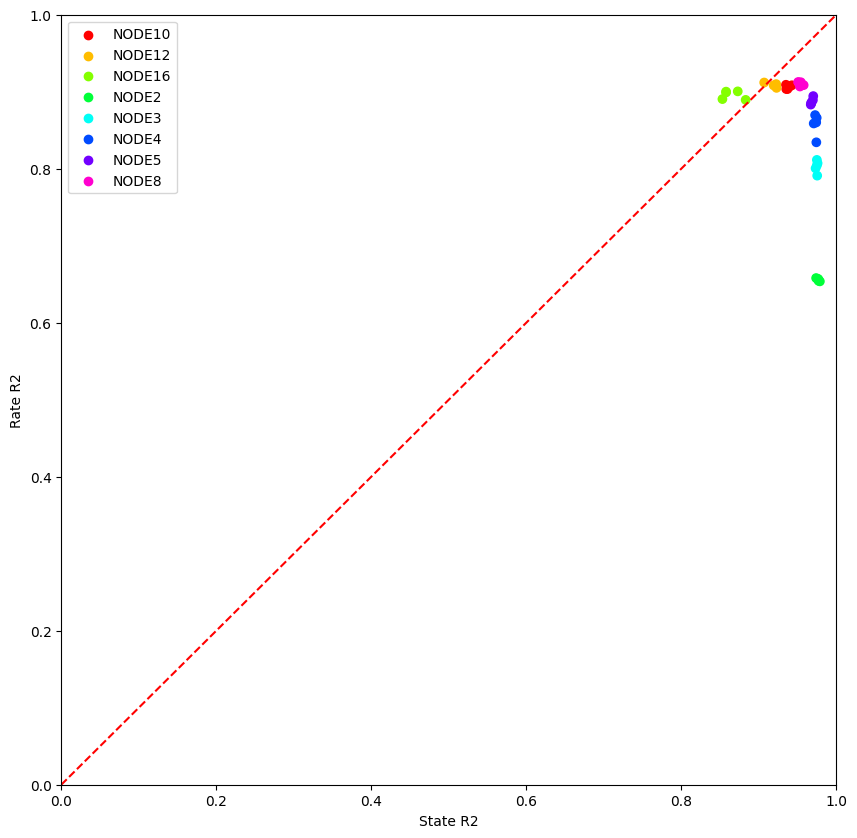

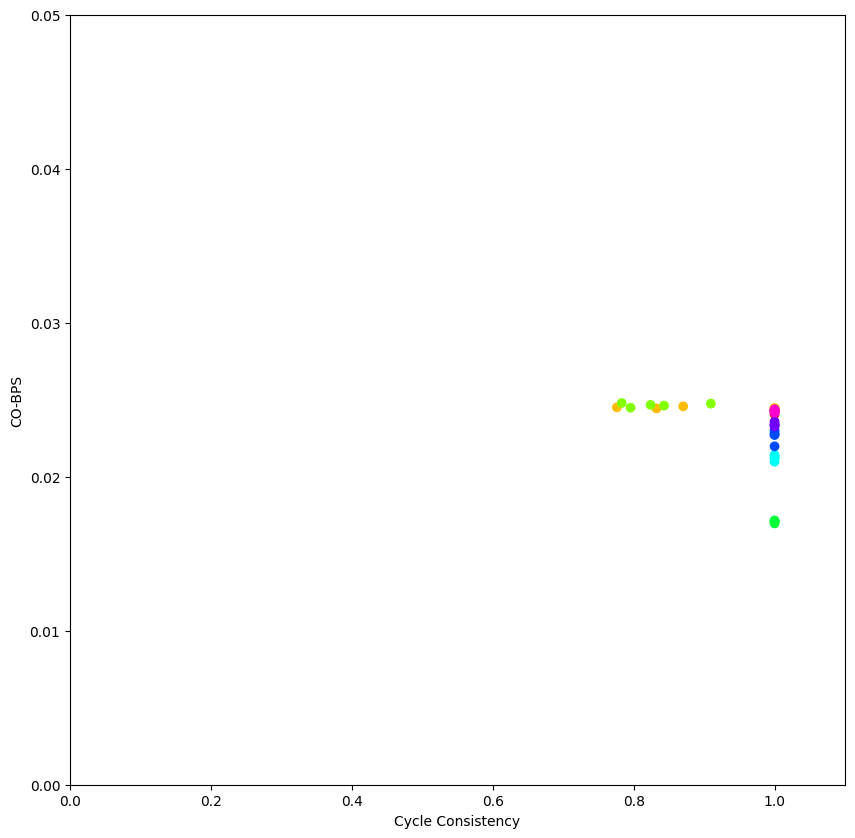

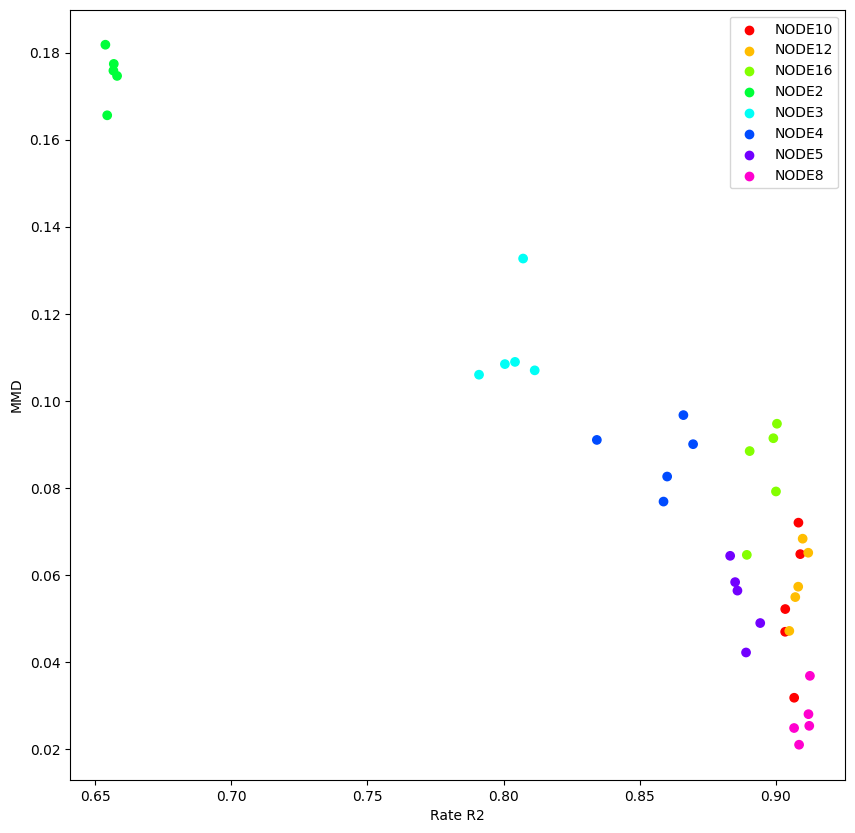

In [7]:
groups = metrics['group']
unique_groups = np.unique(groups)
print(groups)
print(unique_groups)
# group_indices = [np.where(groups == group)[0] for group in unique_groups]
colors1 = plt.cm.hsv(np.linspace(0, 1, len(unique_groups)+1))
colors_list = []
for i, group in enumerate(groups):
    colors_list.append(colors1[np.where(unique_groups == group)[0][0]])
    
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics['state_r2'], metrics['rate_r2'], c = colors_list)
ax.set_xlabel("State R2")
ax.set_ylabel("Rate R2")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.plot([0, 1], [0, 1], 'r--')
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
ax.legend()

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics['cycle_con'], metrics['co-bps'], c = colors_list)
ax.set_xlabel("Cycle Consistency")
ax.set_ylabel("CO-BPS")
ax.set_xlim([0, 1.1])
ax.set_ylim([0, 0.05])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(metrics['rate_r2'], metrics['mmd'], c = colors_list)
ax.set_xlabel("Rate R2")
ax.set_ylabel("MMD")
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)
ax.legend()
ax.legend()



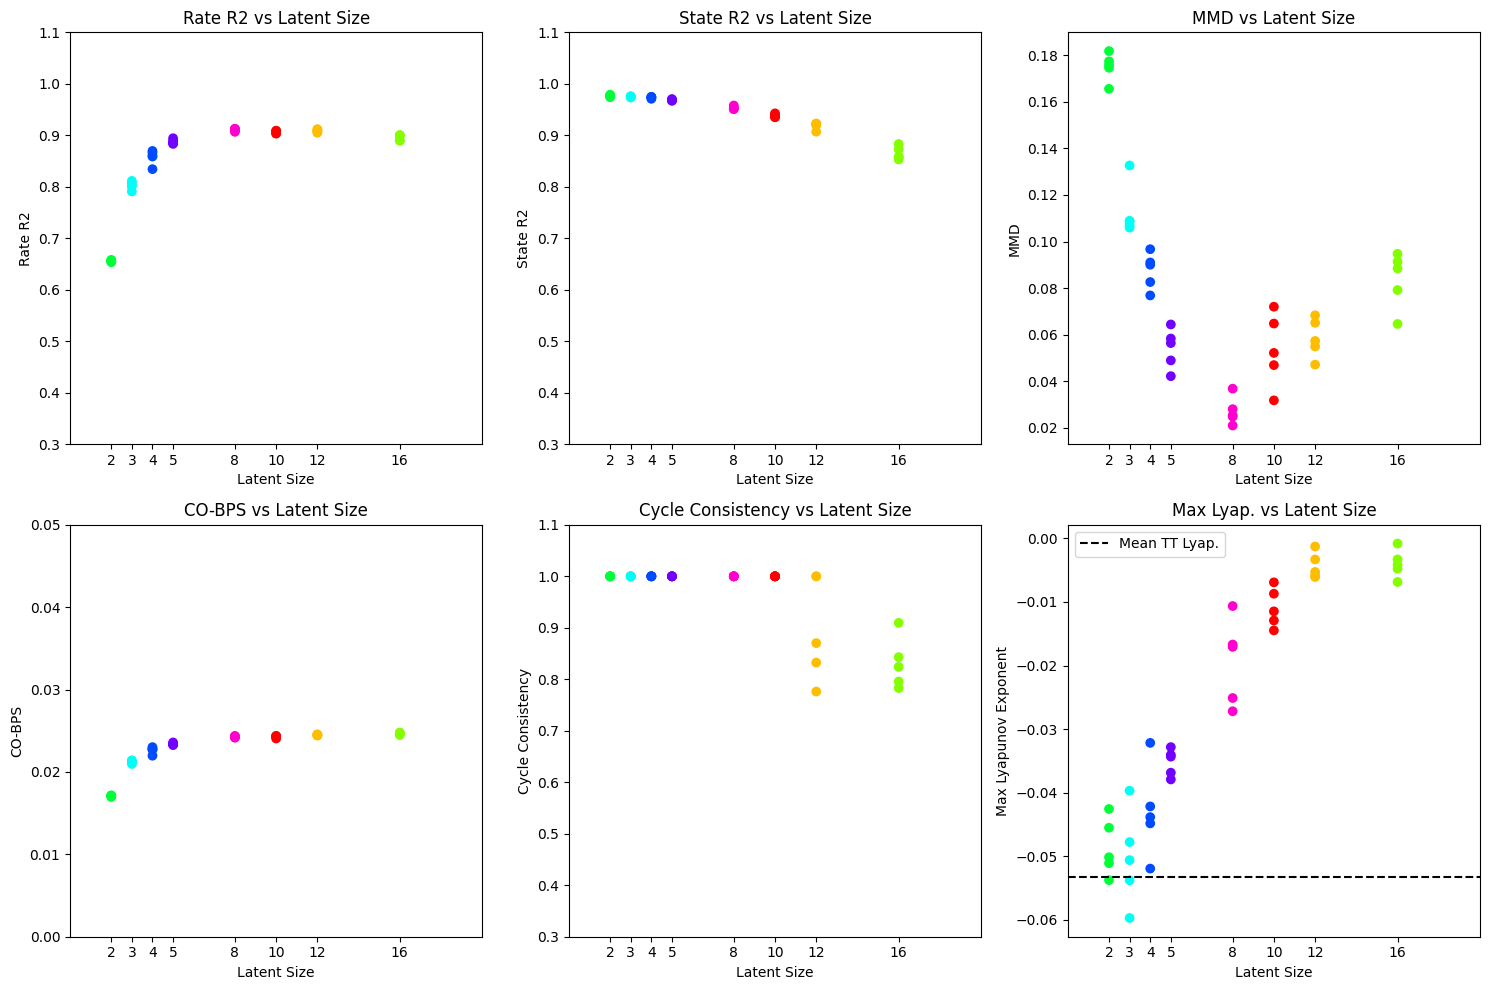

In [8]:
# Make a folder for the plots
if not os.path.exists("lat_size_plots"):
    os.makedirs("lat_size_plots")
lat_size = []
for group in groups:
    lat_size.append(int(group.split("NODE")[1].split("_")[0]))
u_lat_size = np.unique(lat_size)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(2, 3, 1)
ax.scatter(lat_size, metrics['rate_r2'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("Rate R2")
ax.set_xlim([0, 20])
ax.set_ylim([0.3, 1.1])
ax.set_title("Rate R2 vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2, 3, 2)
ax.scatter(lat_size, metrics['state_r2'], c = colors_list )
ax.set_xlabel("Latent Size")
ax.set_ylabel("State R2")
ax.set_xlim([0, 20])
ax.set_ylim([0.3, 1.1])
ax.set_xticks(u_lat_size)
ax.set_title("State R2 vs Latent Size")

ax = fig.add_subplot(2,3,3)
ax.scatter(lat_size, metrics['mmd'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("MMD")
ax.set_xlim([0, 20])
ax.set_title("MMD vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2,3,4)
ax.scatter(lat_size, metrics['co-bps'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("CO-BPS")
ax.set_xlim([0, 20])
ax.set_ylim([0.0, 0.05])
ax.set_title("CO-BPS vs Latent Size")
ax.set_xticks(u_lat_size)

ax = fig.add_subplot(2, 3, 5)
ax.scatter(lat_size, metrics['cycle_con'], c = colors_list)
ax.set_xlabel("Latent Size")
ax.set_ylabel("Cycle Consistency")
ax.set_xlim([0, 20])
ax.set_ylim([0.3, 1.1])
ax.set_title("Cycle Consistency vs Latent Size")
ax.set_xticks(u_lat_size)

lyaps = []
for ly in metrics['lyapunov']:
    lyaps.append(ly[0])
ax = fig.add_subplot(2,3,6)
ax.scatter(lat_size, lyaps, c = colors_list)
ax.axhline(lex_TT_mean[0].detach().numpy(), color='k', linestyle='--', label='Mean TT Lyap.')
ax.legend()
ax.set_xlabel("Latent Size")
ax.set_ylabel("Max Lyapunov Exponent")
ax.set_xlim([0, 20])
ax.set_title("Max Lyap. vs Latent Size")
ax.set_xticks(u_lat_size)
plt.tight_layout()
plt.savefig("lat_size_plots/RandomTargetCompiledVsLatentSize.pdf", dpi=300, bbox_inches='tight')


dict_keys(['val_r2', 'noise_stds', 'r2_per_noise', 'enc_state_dict', 'scalers'])


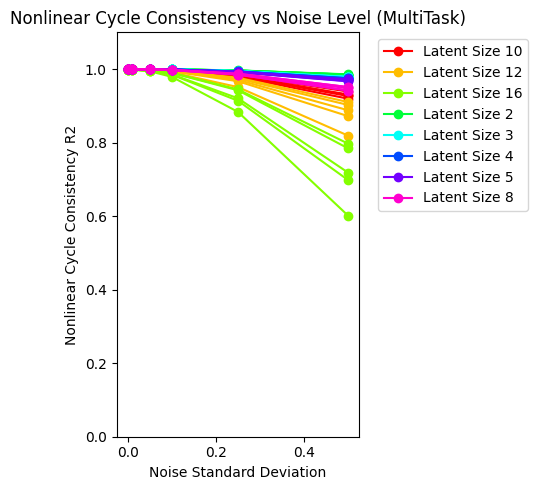

In [9]:
print(metrics['nl_cycle_con'][0].keys())
fig= plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
lat_size_included = []
nl_ccs = metrics['nl_cycle_con']
for i, nl_cc in enumerate(nl_ccs):
    if lat_size[i] in lat_size_included:
        label = None
    else:
        label = f"Latent Size {lat_size[i]}"
    lat_size_included.append(lat_size[i])
    noise_levels = nl_cc['noise_stds']
    r2_per_noise = nl_cc['r2_per_noise']
    ax.plot(noise_levels, r2_per_noise, marker='o', label=label, color=colors_list[i])
    # Make x axis log scale
# Print legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylim([0, 1.1])
ax.set_xlabel("Noise Standard Deviation")
ax.set_ylabel("Nonlinear Cycle Consistency R2")
ax.set_title("Nonlinear Cycle Consistency vs Noise Level (MultiTask)")
# Save as pdf
plt.tight_layout()
plt.savefig("lat_size_plots/RandomTarget_NonLinearCycleConsistency_vs_Noise.pdf", dpi=300, bbox_inches='tight')

(40, 6)


/tmp/ipykernel_15889/4077812200.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)


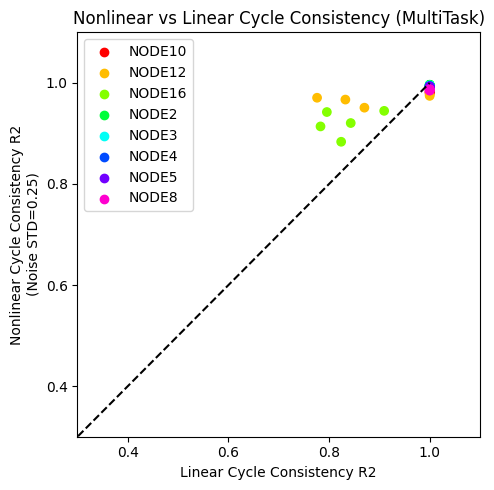

In [10]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

nl_ccs = metrics['nl_cycle_con']
unique_noises = nl_ccs[0]['noise_stds']  # assume same noise_stds for all runs
num_noises = len(unique_noises)
noise_ind = 4

# Build an array: rows = latent sizes, cols = noise levels
all_r2 = np.array([cc['r2_per_noise'] for cc in nl_ccs])  # shape (n_latent_sizes, n_noise_levels)
print(all_r2.shape)
noise_level_r2 = all_r2[:, noise_ind]

ax.scatter(metrics['cycle_con'], noise_level_r2, c = colors_list)

# Add legend for latent sizes
for legend_group in unique_groups:
    ax.scatter([], [], c=colors1[np.where(unique_groups == legend_group)[0][0]], label=legend_group)

ax.legend()
# Plot unity line
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.3, 1.1])
ax.set_ylim([0.3, 1.1])
ax.set_xticks([0.4, 0.6, 0.8, 1.0])
ax.set_yticks([0.4, 0.6, 0.8, 1.0])
ax.set_xlabel("Linear Cycle Consistency R2")
ax.set_ylabel(f"Nonlinear Cycle Consistency R2\n(Noise STD={unique_noises[noise_ind]})")
ax.set_title("Nonlinear vs Linear Cycle Consistency (MultiTask)")

plt.tight_layout()
plt.savefig("lat_size_plots/RandomTarget_NonLinear_vs_Linear_CycleConsistency.pdf", dpi=300, bbox_inches='tight')